<a href="https://colab.research.google.com/github/Sina-Haz/fastai-kaggle/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

os.environ['KAGGLE_USERNAME'] = 'shazeghi'
os.environ['KAGGLE_KEY'] = '87607fda13bdf94dc22bbf70ef2383fb'

In [2]:
# Firstly lets download dataset:
from pathlib import Path
import os

path = Path('titanic')

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    # if on kaggle we assume we already have data in the directory
    !pip install -Uqq fastai # TODO if on a kaggle notebook (this won't work when we go offline though :/)
elif not os.path.exists(path):
    import zipfile,kaggle
    !kaggle competitions download -c titanic
    zipfile.ZipFile(f'{path}.zip').extractall(path)

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 2.32MB/s]


### Data Cleaning and EDA

In [3]:
# Load data
import pandas as pd
import torch, numpy as np

df = pd.read_csv(path/'train.csv')
eval_df = pd.read_csv(path/'test.csv')

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
df.isna().sum() # Need to fill in missing values, can do this by filling them in with mode

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [7]:
modes = df.mode(axis=0).iloc[0]

df = df.fillna(modes)
df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


array([[<Axes: title={'center': 'Fare'}>]], dtype=object)

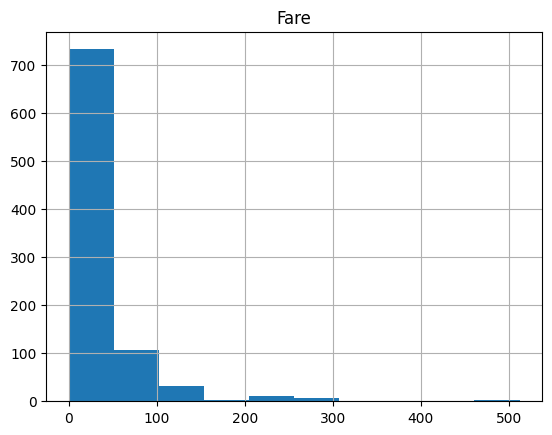

In [8]:
df.hist('Fare') # We see the fare is a long tail distribution, apply log to it to make both linear model and nn better behaved

In [9]:
df['LogFare'] = torch.log(torch.tensor(df['Fare']+1))

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S,2.110213
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,4.280593
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S,2.188856
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.990834
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B96 B98,S,2.202765


In [10]:
# for categorical variables, want to make them binary by adding extra columns per category, can do this with pandas
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


array([[<Axes: title={'center': 'Survived'}>]], dtype=object)

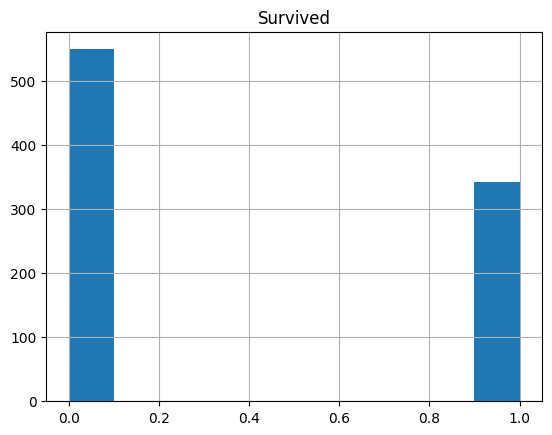

In [11]:
df.hist('Survived')

In [12]:
df = pd.get_dummies(df, columns = ['Sex', 'Pclass', 'Embarked'])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [13]:
added_cols = list(df.columns[len(df.columns)-8:])
added_cols

indep_cols = ['Age', 'SibSp', 'LogFare', 'Parch'] + added_cols

dep = df.Survived

In [14]:
print(df[indep_cols].dtypes)
df[indep_cols].astype(float)

Age           float64
SibSp           int64
LogFare       float64
Parch           int64
Sex_female       bool
Sex_male         bool
Pclass_1         bool
Pclass_2         bool
Pclass_3         bool
Embarked_C       bool
Embarked_Q       bool
Embarked_S       bool
dtype: object


,Age,SibSp,LogFare,Parch,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1.0,2.110213,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,38.0,1.0,4.280593,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,26.0,0.0,2.188856,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,35.0,1.0,3.990834,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,35.0,0.0,2.202765,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0.0,2.639057,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
887,19.0,0.0,3.433987,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
888,24.0,1.0,3.196630,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
889,26.0,0.0,3.433987,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [15]:
# Now convert data to tensors so we can train on it
from torch import tensor

t_dep = tensor(dep)
t_indep = tensor(df[indep_cols].astype(float).values, dtype=torch.float)

### Setting up our Linear Model

In [16]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeff = torch.rand(n_coeff)-0.5 # to get random coefficients b/w (-.5, .5)

In [17]:
# Now all we need to do to feed forward our linear model is multiply each row by coeffs and sum
# Since for all categorical values we have its own column, no need for bias term

(t_indep*coeff) # can do this multiplication easily and element wise using broadcasting
# we can see though that the age column much larger than all the others

tensor([[-10.1838,   0.1386,   0.5084,  ...,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   1.0312,  ...,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.5273,  ...,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.1096,   0.1386,   0.7701,  ...,  -0.0000,   0.0000,   0.3625],
        [-12.0354,   0.0000,   0.8273,  ...,  -0.4392,   0.0000,   0.0000],
        [-14.8128,   0.0000,   0.5225,  ...,  -0.0000,   0.2103,   0.0000]])

In [18]:
max, ind = torch.max(t_indep, axis=0)
t_indep /= max
t_indep

tensor([[0.2750, 0.1250, 0.3381,  ..., 0.0000, 0.0000, 1.0000],
        [0.4750, 0.1250, 0.6859,  ..., 1.0000, 0.0000, 0.0000],
        [0.3250, 0.0000, 0.3507,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.3000, 0.1250, 0.5122,  ..., 0.0000, 0.0000, 1.0000],
        [0.3250, 0.0000, 0.5502,  ..., 1.0000, 0.0000, 0.0000],
        [0.4000, 0.0000, 0.3476,  ..., 0.0000, 1.0000, 0.0000]])

In [19]:
raw_preds = (t_indep*coeff).sum(axis=1) # to get our raw predictions

In [20]:
raw_preds[:10]

tensor([ 0.2992, -0.2521,  0.3132,  0.5557,  0.2102,  0.1233,  0.3761,  0.4498,
         0.2439, -0.3199])

In [21]:
# can just use L1 dist as loss for this to keep it simple
loss = torch.abs(raw_preds - t_dep).mean()
loss

tensor(0.5036)

In [22]:
# now lets just make that into a function lol
def get_preds(indep, coeff): return (indep*coeff).sum(axis=1)
def get_loss(indep, coeff, dep): return torch.abs(get_preds(indep, coeff) - dep).mean()

### A Gradient Descent Step


In [23]:
coeff.requires_grad_() # make it so that the weights need to keep track of gradients (with the last underscore it does it in place)

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,
         0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [24]:
loss=get_loss(t_indep, coeff, t_dep)
loss

tensor(0.5036, grad_fn=<MeanBackward0>)

In [25]:
loss.backward()

In [26]:
coeff.grad

tensor([ 0.0185,  0.0146, -0.0260, -0.0049, -0.1930,  0.2458, -0.1212, -0.0090,
         0.1829, -0.1886,  0.0101,  0.2312])

In [27]:
# Use with torch.no_grad() so that gradient descent step doesn't affecting grad calculations
lr = 0.1
with torch.no_grad():
  coeff -= coeff.grad*lr
  print(get_loss(t_indep, coeff, t_dep))

tensor(0.4801)


### Linear Model Training Loop


In [28]:
# Get a training and validation set now:
rand_inds = np.random.permutation(range(len(df)))

val_prop = .2
vlen = int(val_prop * len(df))

val_inds = rand_inds[:vlen-1]
trn_inds = rand_inds[vlen:]


In [29]:
print(type(trn_inds), trn_inds.shape if isinstance(trn_inds, np.ndarray) else len(trn_inds))
print(type(val_inds), val_inds.shape if isinstance(val_inds, np.ndarray) else len(val_inds))

<class 'numpy.ndarray'> (713,)
<class 'numpy.ndarray'> (177,)


In [30]:
trn_indep, trn_dep = t_indep[trn_inds], t_dep[trn_inds]
val_indep, val_dep = t_indep[val_inds], t_dep[val_inds]

In [31]:
def init_coeffs():
  return (torch.rand(len(indep_cols))-0.5).requires_grad_()


def one_epoch(coeffs, lr):
  loss = get_loss(trn_indep, coeffs, trn_dep) # calculate loss from training data
  loss.backward()

  with torch.no_grad():
    coeffs-=coeffs.grad*lr
    print(f'{loss:.3f}')

  coeffs.grad.zero_()  # Zero out gradients for the next iteration

def train(num_epochs=30, lr=0.2):
  coeffs = init_coeffs()
  for i in range(num_epochs): one_epoch(coeffs, lr)
  return coeffs

def get_accuracy(coeffs):
  res = (get_preds(val_indep, coeffs) > 0.5)
  print((res==val_dep).sum() / len(val_dep))


In [32]:
get_accuracy(coeff)

coeffs = train()

get_accuracy(coeffs)

tensor(0.5932)
0.832
0.509
0.434
0.376
0.374
0.386
0.379
0.347
0.348
0.343
0.341
0.319
0.320
0.315
0.315
0.302
0.304
0.297
0.303
0.289
0.294
0.278
0.286
0.275
0.290
0.282
0.307
0.290
0.311
0.277
tensor(0.7853)


### Using Sigmoid to make optimization easier

right now our problem is hard to optimize b/c we need to make our coefficients such that every row should sum up to exactly zero. If instead we pass through a sigmoid layer we can just have the sum of every row be either large or small and that will point to either 0 or 1 which is our desired output

In general this is something we always want to check for when trying to build a binary classifying model, that it finally spits it out through sigmoid

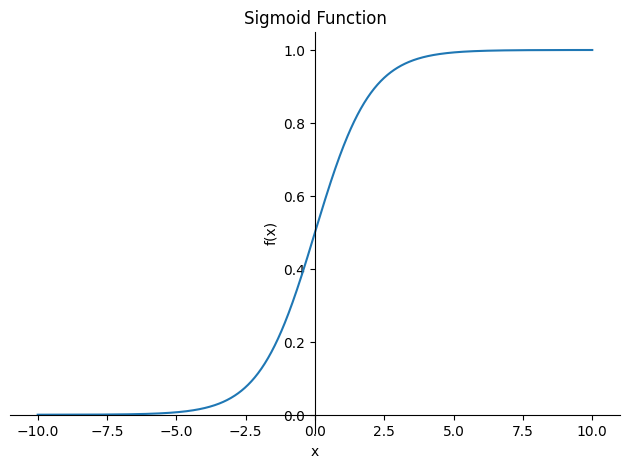

In [33]:
import sympy as sp

# Define the symbol and the sigmoid function
x = sp.symbols('x')
sigmoid = 1 / (1 + sp.exp(-x))

# Plot the sigmoid function
sp.plot(sigmoid, (x, -10, 10), title="Sigmoid Function", ylabel="f(x)", xlabel="x");


In [34]:
# overwrite the way we get predictions and don't need to change anything else

def get_preds(indep, coeff): return torch.sigmoid((indep*coeff).sum(axis=1))

In [35]:
c=train(num_epochs = 100, lr=5) # can now train much faster b/c easier to optimize so we made the learning rate much larger
get_accuracy(c)

0.499
0.393
0.332
0.306
0.290
0.277
0.268
0.260
0.254
0.249
0.245
0.242
0.239
0.237
0.235
0.233
0.231
0.230
0.228
0.227
0.226
0.225
0.224
0.223
0.222
0.221
0.221
0.220
0.219
0.219
0.218
0.217
0.217
0.216
0.216
0.215
0.215
0.214
0.214
0.213
0.213
0.213
0.212
0.212
0.211
0.211
0.211
0.210
0.210
0.210
0.209
0.209
0.209
0.208
0.208
0.208
0.207
0.207
0.207
0.207
0.206
0.206
0.206
0.206
0.205
0.205
0.205
0.205
0.204
0.204
0.204
0.204
0.204
0.203
0.203
0.203
0.203
0.203
0.202
0.202
0.202
0.202
0.202
0.202
0.201
0.201
0.201
0.201
0.201
0.201
0.200
0.200
0.200
0.200
0.200
0.200
0.200
0.200
0.199
0.199
tensor(0.7910)


### Submitting to Kaggle


In [36]:
# read in test set
tst_df = pd.read_csv(path/'test.csv')
tst_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [37]:
# apply same methods to it to fill its na
tst_df.fillna(tst_df.mode().iloc[0], inplace=True)

tst_df['LogFare'] = torch.log(torch.tensor(tst_df['Fare']+1))

tst_df = pd.get_dummies(tst_df, columns = ['Sex', 'Pclass', 'Embarked'])

indep = tensor(tst_df[indep_cols].astype(float).values)

max,ind = torch.max(indep, axis=0)
max

tensor([76.0000,  8.0000,  6.2409,  9.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000], dtype=torch.float64)

In [38]:
# Normalize all values
indep/=max
indep

tensor([[0.4539, 0.0000, 0.3490,  ..., 0.0000, 1.0000, 0.0000],
        [0.6184, 0.1250, 0.3332,  ..., 0.0000, 0.0000, 1.0000],
        [0.8158, 0.0000, 0.3796,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5066, 0.0000, 0.3381,  ..., 0.0000, 0.0000, 1.0000],
        [0.2763, 0.0000, 0.3530,  ..., 0.0000, 0.0000, 1.0000],
        [0.2763, 0.1250, 0.5049,  ..., 1.0000, 0.0000, 0.0000]],
       dtype=torch.float64)

In [39]:
survived = (get_preds(indep, c) > 0.5).int()
survived

tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,

In [40]:
tst_df['Survived'] = survived
final=(tst_df[['PassengerId', 'Survived']])
final.to_csv('final.csv', index=False)

In [41]:
! head /content/final.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


In [42]:
# ! kaggle competitions submit -c titanic -f /content/final.csv -m "linear model"

In [43]:
!kaggle competitions submissions -c titanic

fileName    date                 description   status    publicScore  privateScore  
----------  -------------------  ------------  --------  -----------  ------------  
nn_res.csv  2024-08-29 14:07:44  MLP model     complete  0.77751                    
final.csv   2024-08-28 22:45:56  linear model  complete  0.77751                    
final.csv   2024-08-28 17:39:52  linear model  complete  0.77751                    
final.csv   2024-08-28 17:37:38  linear model  error                                


### Adding in Matrix Multiplication and Neural Networks


In [44]:
# Notice that what we were doing before (element wise multiplication and summing along the columns) is actually matrix multiplication
print((indep * c).sum(axis=1)[:10])

tensor([-6.5207, -1.1413, -2.3133, -9.1104, -1.1018, -9.0450,  1.6520, -4.9029,
         1.0561, -9.1899], dtype=torch.float64, grad_fn=<SliceBackward0>)


In [45]:
c=c.double() # to fix an issue b/w different dtypes
(indep@c)[:10]

tensor([-6.5207, -1.1413, -2.3133, -9.1104, -1.1018, -9.0450,  1.6520, -4.9029,
         1.0561, -9.1899], dtype=torch.float64, grad_fn=<SliceBackward0>)

In [46]:
# Update our get prediction function and other functions to be rank 2 (column vectors)
def get_preds(indep, coeff):
  return torch.sigmoid(indep@coeff)

def init_coeffs(): return (torch.rand((len(indep_cols), 1)) - 0.5).requires_grad_()

trn_dep = trn_dep[:, None]
val_dep = val_dep[:, None]


In [47]:
coeffs = train(num_epochs=50, lr=2)
get_accuracy(coeffs)

0.533
0.489
0.448
0.416
0.393
0.376
0.363
0.353
0.344
0.336
0.329
0.322
0.315
0.309
0.303
0.297
0.292
0.287
0.283
0.279
0.275
0.272
0.268
0.265
0.263
0.260
0.258
0.256
0.254
0.252
0.251
0.249
0.248
0.246
0.245
0.244
0.243
0.242
0.241
0.240
0.239
0.238
0.237
0.236
0.235
0.235
0.234
0.233
0.233
0.232
tensor(0.7853)


In [48]:
# Now to make it a neural network, instead of just having matrix multiply return 1 output and that being the only layer
# we can make a hidden layer by making our weights be a matrix instead of column vector and then dot producting that into
# our final output, for now we will do a 2 layer nn
def init_coeffs(n_hidden=20):
  layer1 = (torch.rand((len(indep_cols), n_hidden)) - 0.5)/n_hidden # divide by n_hidden to keep gradients small so training is more stable
  layer2 = torch.rand((n_hidden, 1)) - 0.5
  const = torch.rand(1)[0] # use a constant term to add to second layer (didn't need for 1st layer b/c of extra dummy variables)
  ws = [layer1, layer2, const]
  return [w.requires_grad_() for w in ws]


In [49]:
import torch.nn.functional as F

# Now to get predictions we need to feed forward inputs through both layers and we use a ReLU activation fn until the end layer
def get_preds(inp, coeffs):
  layer1, layer2, const = coeffs
  res1 = F.relu(inp@layer1)
  res2 = res1@layer2 + const
  return torch.sigmoid(res2)

# just need to add loop now that we have multiple weight matrices
def one_epoch(coeffs, lr):
  loss = get_loss(trn_indep, coeffs, trn_dep)
  loss.backward()

  with torch.no_grad():
    for c in coeffs: c-=c.grad*lr
    print(f'{loss:.3f}')

  for c in coeffs: c.grad.zero_()

coeffs = train(num_epochs=50, lr=2)
get_accuracy(coeffs) # looks like with nn we are getting slightly better results than before both in loss and accuracy

0.505
0.473
0.430
0.390
0.360
0.340
0.325
0.310
0.296
0.284
0.273
0.262
0.253
0.244
0.238
0.232
0.228
0.224
0.221
0.218
0.216
0.214
0.212
0.211
0.209
0.208
0.207
0.205
0.204
0.203
0.202
0.202
0.201
0.200
0.199
0.199
0.198
0.197
0.197
0.196
0.196
0.195
0.195
0.195
0.194
0.194
0.193
0.193
0.193
0.193
tensor(0.7910)


### Deep Learning

Now lets implement neural network models with n hidden layers

In [50]:
def init_coeffs():
  hiddens = [5, 3] # <-- change this to be as many hidden layers as you want
  sizes = [len(indep_cols)] + hiddens + [1] # this is defining all the sizes of layers of our network
  n=len(sizes)
  layers = [(torch.rand((sizes[i], sizes[i+1])) - 0.3)/sizes[i+1]*4 for i in range(n-1)]
  consts = [(torch.rand(1)[0] - 0.5)*0.2 for i in range(n-1)]
  for p in layers+consts: p.requires_grad_()
  return layers, consts

# Only thing we really change about feed forward is looping through all the layers and consts
def get_preds(inp, coeffs):
  layers, consts = coeffs
  res, n = inp, len(layers)
  for i, l in enumerate(layers):
    res = res@l + consts[i]
    if i!=n-1:res = F.relu(res)
  return torch.sigmoid(res)


# just need to adjust loop for how we update coeffs
def one_epoch(coeffs, lr):
  loss = get_loss(trn_indep, coeffs, trn_dep)
  loss.backward()

  with torch.no_grad():
    layers, consts = coeffs
    for c in layers+consts: c-=c.grad*lr
    print(f'{loss:.3f}')

  for c in layers+consts: c.grad.zero_()

coeffs = train(num_epochs=50, lr=2)
get_accuracy(coeffs) # playing around with this it seems that a smaller neural network does much better on this task
# than a larger one, and all around we aren't doing that much better than our original linear model

0.583
0.495
0.460
0.446
0.394
0.362
0.326
0.280
0.244
0.231
0.225
0.222
0.220
0.219
0.218
0.217
0.217
0.216
0.216
0.216
0.215
0.215
0.215
0.215
0.215
0.215
0.215
0.215
0.214
0.214
0.214
0.214
0.214
0.214
0.214
0.214
0.214
0.214
0.214
0.214
0.214
0.214
0.214
0.214
0.214
0.214
0.214
0.214
0.214
0.214
tensor(0.7853)


This is about as good as we are going to get with a vanilla MLP approach.

To get even better we will need to use feature engineering to find better predictors within our dataset

In [51]:
# lets upload this to kaggle
indep = indep.float()
survived = (get_preds(indep, coeffs) > 0.5).int()
tst_df['Survived'] = survived
sub_df = (tst_df[['PassengerId', 'Survived']]).copy()
sub_df.to_csv('nn_res.csv', index=False)

In [52]:
# ! kaggle competitions submit -c titanic -f /content/nn_res.csv -m "MLP model"

In [53]:
!kaggle competitions submissions -c titanic

fileName    date                 description   status    publicScore  privateScore  
----------  -------------------  ------------  --------  -----------  ------------  
nn_res.csv  2024-08-29 14:07:44  MLP model     complete  0.77751                    
final.csv   2024-08-28 22:45:56  linear model  complete  0.77751                    
final.csv   2024-08-28 17:39:52  linear model  complete  0.77751                    
final.csv   2024-08-28 17:37:38  linear model  error                                


### Getting Better results and doing more with a Framework


In [54]:
! pip install -Uq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.5/234.5 kB 16.1 MB/s eta 0:00:00


In [55]:
from fastai.imports import *
from fastai.tabular.all import *
df = pd.read_csv(path/'train.csv')

In [56]:
# With a framework, don't need to worry as much about low level stuff so do as much feature engineering as we want
# grabbed this from the following notebook: https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial

def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

add_features(df)


In [57]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2.110213,NaN,1,False,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,4.280593,ABC,1,False,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2.188856,NaN,0,True,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.990834,ABC,1,False,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,2.202765,NaN,0,True,1,Mr


In [58]:
splits = RandomSplitter(seed=42)(df)

In [79]:
# load in the data thru framework dataloaders, TabularPandas is a function to preprocess tabular data
# TabularPandas returns a dataframe like object that is organized with independent and dependent variables under different sections
# Can easily work into other frameworks such as Random Forests or XGBoost
# For more info check the docs: https://docs.fast.ai/tutorial.tabular.html
dls = TabularPandas(
    df,
    procs = [Categorify, FillMissing, Normalize], # pass in the procedures you want done on the data, these are in the form of fastai class so we can specify in more depth how we want them done
    cat_names = ['Sex', 'Pclass', 'Embarked', 'Deck', 'Title'], # specify categorical columns
    cont_names = ['Age', 'LogFare', 'Parch', 'SibSp', 'TicketFreq', 'Alone', 'Family'],
    y_names = 'Survived', y_block = CategoryBlock(),# specify label column and what type it is
).dataloaders(path='.')

In [80]:
learn = tabular_learner(dls, layers=[8, 8], metrics=accuracy)

/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your 

SuggestedLRs(slide=0.10000000149011612, valley=0.0063095735386013985)

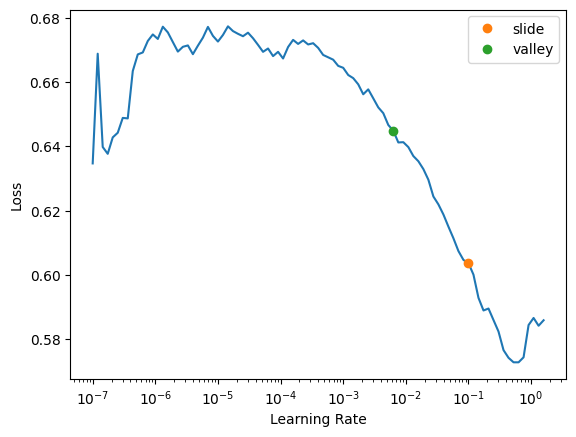

In [81]:
# use this function to find a good learning rate
learn.lr_find(suggest_funcs = (slide, valley))

In [82]:
learn.fit(16, lr=.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.523631,None,None,00:00
1,0.479527,None,None,00:00
2,0.447791,None,None,00:00
3,0.437033,None,None,00:00
4,0.413739,None,None,00:00
5,0.404766,None,None,00:00
6,0.396281,None,None,00:00
7,0.394367,None,None,00:00
8,0.394302,None,None,00:00
9,0.391473,None,None,00:00


/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your 

In [87]:

dls = TabularPandas(
    df,
    procs = [Categorify, FillMissing, Normalize], # pass in the procedures you want done on the data, these are in the form of fastai class so we can specify in more depth how we want them done
    cat_names = ['Sex', 'Pclass', 'Embarked', 'Deck', 'Title'], # specify categorical columns
    cont_names = ['Age', 'LogFare', 'Parch', 'SibSp', 'TicketFreq', 'Alone', 'Family'],
    y_names = 'Survived', y_block = CategoryBlock(),# specify label column and what type it is
)
# Looks like the issue is because our validation set is EMPTY, all we needed to do is add our random splitter into the mix
len(dls.train), len(dls.valid)

(891, 0)

In [99]:
dls = TabularPandas(
    df,splits=splits,
    procs = [Categorify, FillMissing, Normalize], # pass in the procedures you want done on the data, these are in the form of fastai class so we can specify in more depth how we want them done
    cat_names = ['Sex', 'Pclass', 'Embarked', 'Deck', 'Title'], # specify categorical columns
    cont_names = ['Age', 'LogFare', 'Parch', 'SibSp', 'TicketFreq', 'Alone', 'Family'],
    y_names = 'Survived', y_block = CategoryBlock(),# specify label column and what type it is
).dataloaders(path='.')
learn = tabular_learner(dls, layers=[10, 8], metrics=accuracy)
learn.fit(24, lr=.03)


epoch,train_loss,valid_loss,accuracy,time
0,0.498421,0.665608,0.595506,00:00
1,0.474534,0.492973,0.786517,00:00
2,0.437081,0.445784,0.797753,00:00
3,0.431495,0.421278,0.797753,00:00
4,0.424332,0.407144,0.831461,00:00
5,0.414025,0.420929,0.820225,00:00
6,0.411352,0.418244,0.792135,00:00
7,0.403613,0.420526,0.820225,00:00
8,0.399194,0.411337,0.814607,00:00
9,0.406063,0.414583,0.803371,00:00


### Fastai Submission

In [108]:
# reload the test dataframe so it doesnt have our old pandas preprocessing on it
tst_df = pd.read_csv(path/'test.csv')
# fill empty values in fare before preprocessing
tst_df['Fare'].fillna(0, inplace=True)
# Add the new features to our tst df
add_features(tst_df)
tst_df.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'LogFare', 'Deck', 'Family',
       'Alone', 'TicketFreq', 'Title'],
      dtype='object')

In [109]:
# All the manual steps of preprocessing the dataset into a dataloader are saved in our learner so we can just reuse that
tst_dl = learn.dls.test_dl(tst_df)
tst_dl

In [121]:
preds, _ = learn.get_preds(dl=tst_dl)
preds[:10]

tensor([[0.9298, 0.0702],
        [0.4868, 0.5132],
        [0.9918, 0.0082],
        [0.9138, 0.0862],
        [0.4868, 0.5132],
        [0.9130, 0.0870],
        [0.4868, 0.5132],
        [0.9844, 0.0156],
        [0.4868, 0.5132],
        [0.9408, 0.0592]])

In [115]:
# preds are a 2d matrix where each column represents probs of each category so we need to process them into 0s and 1s
tst_df['Survived'] = (preds[:, 1] > 0.5).int()
sub_df=tst_df[['PassengerId', 'Survived']]
sub_df.to_csv('final.csv', index=False)

In [116]:
! kaggle competitions submit -c titanic -f /content/final.csv -m "Fastai Model"

100% 2.77k/2.77k [00:00<00:00, 3.50kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster

In [117]:
!kaggle competitions submissions -c titanic

fileName    date                 description   status    publicScore  privateScore  
----------  -------------------  ------------  --------  -----------  ------------  
final.csv   2024-09-01 15:41:44  Fastai Model  complete  0.76076                    
nn_res.csv  2024-08-29 14:07:44  MLP model     complete  0.77751                    
final.csv   2024-08-28 22:45:56  linear model  complete  0.77751                    
final.csv   2024-08-28 17:39:52  linear model  complete  0.77751                    
final.csv   2024-08-28 17:37:38  linear model  error                                


### Ensembling

Currently, our framework model does really well.

We can make it even more accurate by combining its predictions with multiple models and having them take a vote (almost like a council of experts)


In [132]:
# Makes a learner, trains it, returns its predictions
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(16, lr=0.03)
    return learn.get_preds(dl=tst_dl)[0]

In [133]:
learns = [ensemble() for _ in range(3)]

In [134]:
ens = torch.stack(learns).mean(0).shape # Get the mean of all the predictions

In [135]:
# submit the same way
tst_df['Survived'] = (preds[:, 1] > 0.5).int()
sub_df=tst_df[['PassengerId', 'Survived']]
sub_df.to_csv('final.csv', index=False)

In [136]:
! kaggle competitions submit -c titanic -f /content/final.csv -m "Ensemble Model 2"

100% 2.77k/2.77k [00:01<00:00, 1.69kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster

In [137]:
!kaggle competitions submissions -c titanic

fileName    date                 description       status    publicScore  privateScore  
----------  -------------------  ----------------  --------  -----------  ------------  
final.csv   2024-09-01 15:54:28  Ensemble Model 2  complete  0.76076                    
final.csv   2024-09-01 15:53:45  Ensemble Model    complete  0.76076                    
final.csv   2024-09-01 15:41:44  Fastai Model      complete  0.76076                    
nn_res.csv  2024-08-29 14:07:44  MLP model         complete  0.77751                    
final.csv   2024-08-28 22:45:56  linear model      complete  0.77751                    
final.csv   2024-08-28 17:39:52  linear model      complete  0.77751                    
final.csv   2024-08-28 17:37:38  linear model      error                                
